# 功能包括：

1.VOC数据集图片的读标签和读图

2.对VOC数据集图片的Preprocess：normalize和inverse_normlize 分为Caffe和Pytorch两种

3.对VOC数据集图片和bbox的resize,random_flip

4.对VOC数据集的类别划分（分为Dataset和TestDataset）


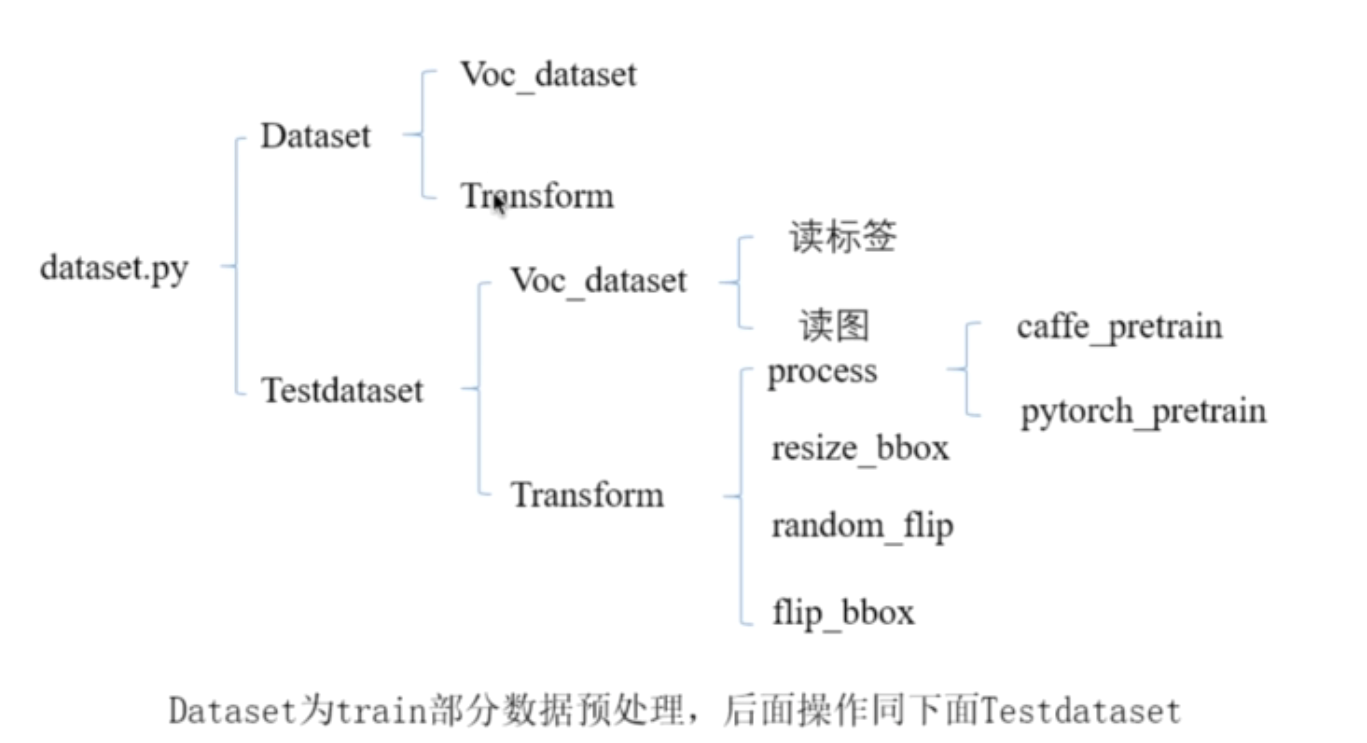

# data/dataset.py

In [ ]:
# inverse_normalize
def inverse_normalize(img):
  if opt.caffe_pretrain:
    img = img +(np.array([122.7717, 115.9465,102.9801]).reshape(3,1,1))
    return img[::-1,:,:]
  return (img*0.225 + 0.45).clip(min=0,max=1)*255

# pytorch normalize
def pytorch_normalize(img):
  normalize = tvtsf.Normalize(mean=[0.485,0.456,0.406],
                              std=[0.229,0.224,0.225])
  img = normalize(t.form_numpy(img))
  return img.numpy()

# caffe normalize
def caffe_normalize(img):
  img = img[[2,1,0],:,:]
  img = img * 255
  mean = np.array([122.7717, 115.9465, 102.9801]).reshape(3,1,1)
  img = (img - mean).astype(np.float32, copy=True)
  return img

# preprocess
def preprocess(img, min_size=600, max_size=1000):
  C,H,W = img.shape
  # 长边不超过1000，短边不超过600 缩放
  scale1 = min_size / min(H,W) 
  scale2 = max_size / max(H,W)
  scale = min(scale1, scale2) #选择小的scale进行缩放
  img = img / 255 #缩放到0～1
  # resize到 (H * scale, W * scale) anti_aliasing为是否高斯滤波
  img = sktsf.resize(img,(C,H * scale, W * scale),mode='reflect', anti_aliasing=False)
  # 选择normalize方式
  if opt.caffe_pretrain:
    normalize = caffe_normalize
  else:
    normalize = pytorch_normalize

# Transform类
class Transform(object):

  def __init__(self, min_size=600, max_size=1000):
    self.min_size = min_size
    self.max_size = max_size
  
  def __call__(self, in_data):
    img, bbox, label = in_data
    _, H, W = img.shape
    # img进行resize等比例缩放 bbox也进行等比例缩放
    img = preprocess(img, self.min_size, self.max_size)
    _, o_H, o_W = img.shape
    scale = o_H / H
    bbox = util.resize_bbox(bbox,(H,W),(o_H,o_W))

    # horizontally flip 图片进行水平翻转 bbox也进行水平的翻转
    img.params = util.random_flip(
        img, x_random=True, return_param=True)
    bbox = util.flip_bbox(
        bbox,(o_H,o_W),x_flip=params['x_flip'])
    
    return img, bbox, label, scale

# data/vocdataset.py

In [ ]:
class VOCBboxDataset:
  def __init__(self,data_dir,split='trainval',
               use_difficult=False, return_difficult=False):
    id_list_file = os.path.join(
        data_dir, 'ImageSets/Main/{0}.txt'.format(split)) # id_list_file为split.txt,split为'trainval'或者'test'
    self.ids = [id_strip() for id_ in open(id_list_file)] #id_为每个样本文件名
    self.data_dir = data_dir #写到/VOC2007/的路径
    self.use_difficult = return_difficult
    self.label_names = VOC_BBOX_LABEL_NAMES

  def __len__(self):
    return len(self.ids)
  
  def get_example(self, i):
    
    id = self.ids[i]
    anno = ET.parse(
        os.path.join(self.data_dir,'Annotations',id_ + '.xml')) # 读入xml标签文件
    bbox = list()
    label = list()
    difficult = list()
    # 解析xml文件
    for obj in anno.findall('object'):
      # 标为difficult的目标在测试评估中一般会被忽略
      if not self.use_difficult and int(obj.find('difficult').text) == 1:
        continue # xml文件中包含object name和difficult(0代表easy)
      
      difficult.append(int(obj,find('difficult').text))
      bndbox_anno = obj.find('bndbox') #bndbox (xmin,ymin,xmax,ymax)表示框在左下角和右上角坐标
      # subtract 1 to make pixel indexes 0-based
      bbox.append([
                   int(bndbox_anno.find(tag).text) - 1
                   for tag in ('ymin','xmin','ymax','xmax')])
      name = obj.find('name').text.lower().strip()
      label.append(VOC_BBOX_LABEL_NAMES.index(name))
    # 存到刚才的列表里
    bbox = np.stack(bbox).astype(np.float32) # 所有object的bbox
    label = np.stack(label).astype(np.int32) # 所有object的label
    difficult = np.array(difficult, dtype=np.bool).astype(np.uint8) #所有object的difficult

    # Load a image
    img_file = os.path.join(self.data_dir, 'JPEGImages',id_ + 'jpg') #根据图片编号在/JPEGImages/取图片
    img = read_images(img_file, color=True) #如果color=True，则转换为RGB图片

    return img, bbox, label, difficult

  __getitem__ = get_example


In [ ]:
class Dataset:
  def __init__(self, opt):
    self.opt = opt
    self.db = VOCBboxDataset(opt.voc_data_dir)
    self.tsf = Transform(opt.min_size, opt_max_size)

  def __getitem__(self, idx):
    # 调用VOCBboxDataset中的get_example()从数据集存储路径中将img,bbox,label,difficult一个个的取出来
    ori_img, bbox, label, difficult = self.db.get_example(idx)
    # 调用前面的Transforme函数将图片,label进行最小值最大值放缩归一化,重新调整bboxes的大小，然后随机翻转，同时记录bbox，最后返回数据集
    img, bbox, label, scale = self.tsf((ori_img, bbox, label))
    return img.copy(), bbox.copy(), label.copy(), scale
  def __len__(self):
    return len(self.db)

class TestDataset: #测试集样本的生成
  def __init__(self, opt, split='test', use_difficult=True):
      self.opt = opt
      self.db = VOCBboxDataset(opt.voc_data_dir, split=split, use_difficult=use_difficult) #此处设置了use_difficult

  def __getitem__(self, idx):
      ori_img, bbox, label, difficult = self.db.get_example(idx)
      img = preprocess(ori_img)
      return img, ori_img.shape[1:], bbox, label, difficult

  def __len__(self):
      return len(self.db)

# data/util.py

In [ ]:
def resize_bbox(bbox, in_size, out_size):
  bbox = bbox.copy()
  y_scale = float(out_size[0]) / in_size[0]
  x_scale = float(out_size[1]) / in_size[1] #获得与原图相同的缩放比
  bbox[:,0] = y_scale * bbox[:,0]
  bbox[:,2] = y_scale * bbox[:,2]
  bbox[:,1] = y_scale * bbox[:,1]
  bbox[:,3] = y_scale * bbox[:,3] # 将bbox坐标也缩放过去

  return bbox 

def random_flip(img, y_random=False, x_random=False,
                return_param=False, copy=False):
  
  y_flip, x_flip = False, False
  if y_random:
    y_flip = random.choice([True, False])
  if x_random:
    x_flip = random.choice([True,False])

  if y_flip:
    img = img[:,::-1,:] #逆序输出 其实就是翻转
  if x_flip:
    img = img[:,:,::-1]

  if copy:
    img = img.copy()
  if return_param:
    return img,{'y_flip':y_flip,'x_flip':x_flip} #返回img和x_flip 为了让bbox有同样的水平翻转操作
  else:
    return img